# Modeling and Evaluation

## Objectives

* Fit a cluster model to group similar data

## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv

## Outputs

* Cluster pipeline
* Train Set
* Cluster Description
* Cluster Silhouette

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv").drop(['SalePrice'], axis=1)
print(df.shape)
df.head(3)

(1460, 23)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotArea  \
0        150            0.0         548          RFn  ...     8450   
1        284            NaN         460          RFn  ...     9600   
2        434            0.0         608          RFn  ...    11250   

   LotFrontage MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  \
0         65.0      196.0           61            5            7          856   
1         80.0        0.0            0            8            6         1262   
2         68.0      162.0           42            5            7          920   

   WoodDeckSF  YearBuilt  YearRemodAdd  
0         0.0       2003          2003  
1         NaN       1976          1976  
2         NaN       2001          2002  

[3 rows x 23 columns]

# Cluster Pipeline

In [5]:
from sklearn.pipeline import Pipeline

from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures
from feature_engine.imputation import  MeanMedianImputer
from feature_engine.imputation import  CategoricalImputer
from feature_engine.imputation import  ArbitraryNumberImputer
from feature_engine.selection import SmartCorrelatedSelection

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=50, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),

    ])

    return pipeline_base

# Principal Component Analysis (PCA)

In [6]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


We will apply PCA separately to the scaled data using CI function

* The 10 components explain 84.24% of the data 



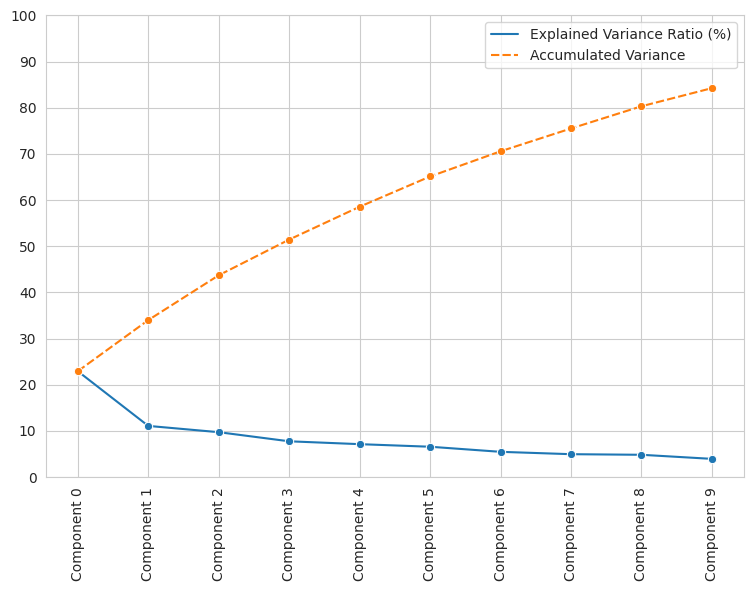

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 10


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

We are looking to cover at least 95% of the data, let's increase the components

* The 14 components explain 96.12% of the data 



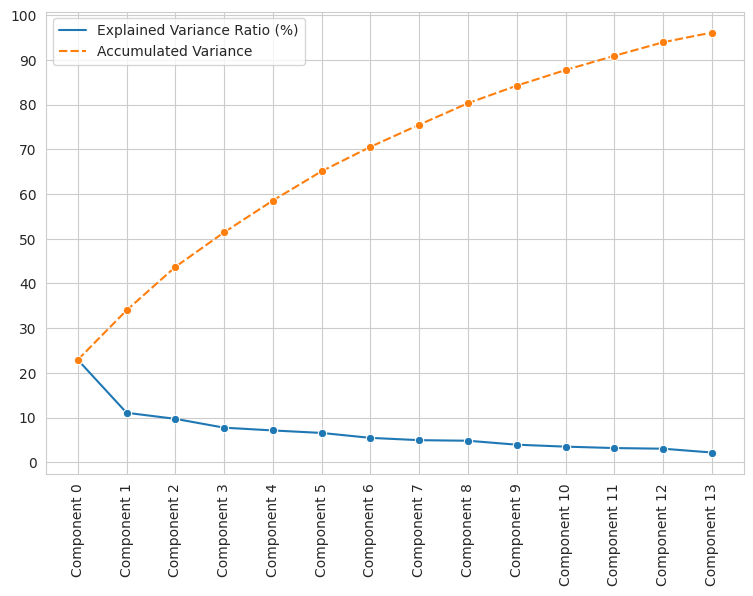

In [8]:
pca_components_analysis(df_pca=df_pca,n_components=14)

Refit the pipeline with the updated components

In [9]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=14, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),

    ])

    return pipeline_base

## Elbow Method

We will use elbow method and silhouette score to determine how many clusters we need

In [10]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


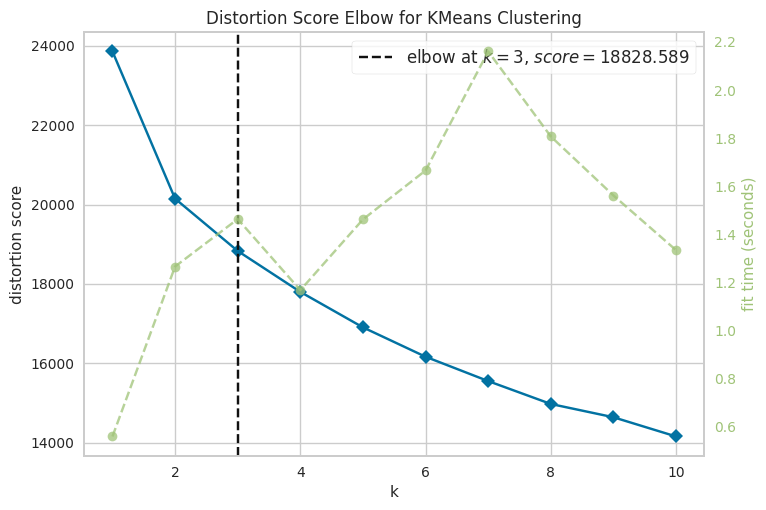

In [11]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

## Silhouette Score

=== Average Silhouette Score for different number of clusters ===


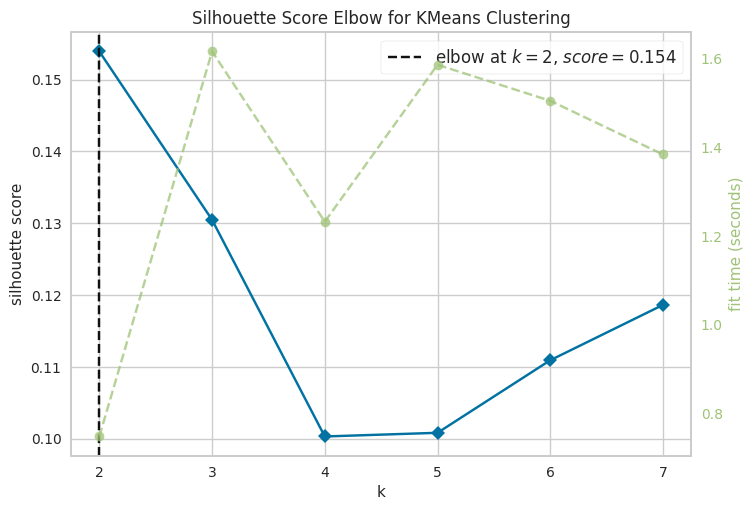



=== Silhouette plot for 2 Clusters ===


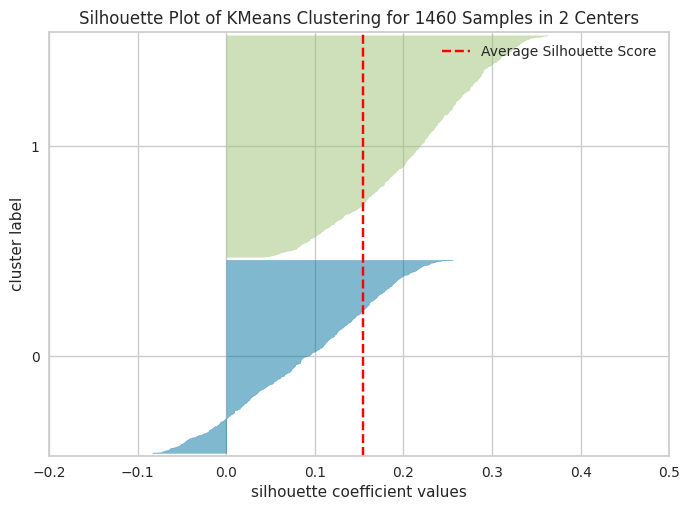



=== Silhouette plot for 3 Clusters ===


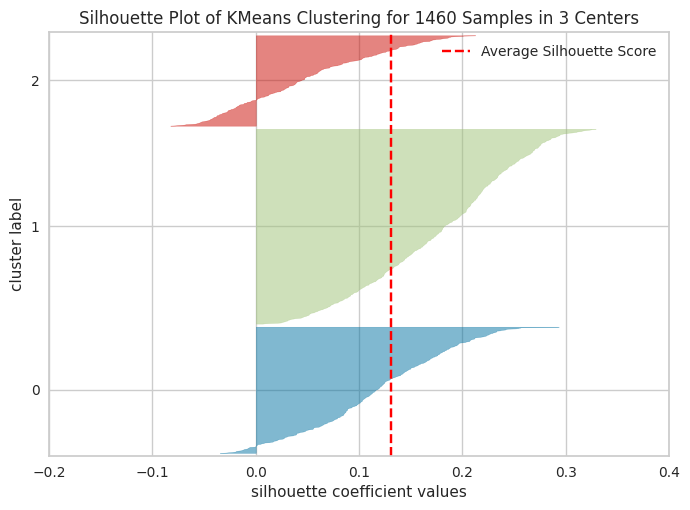



=== Silhouette plot for 4 Clusters ===


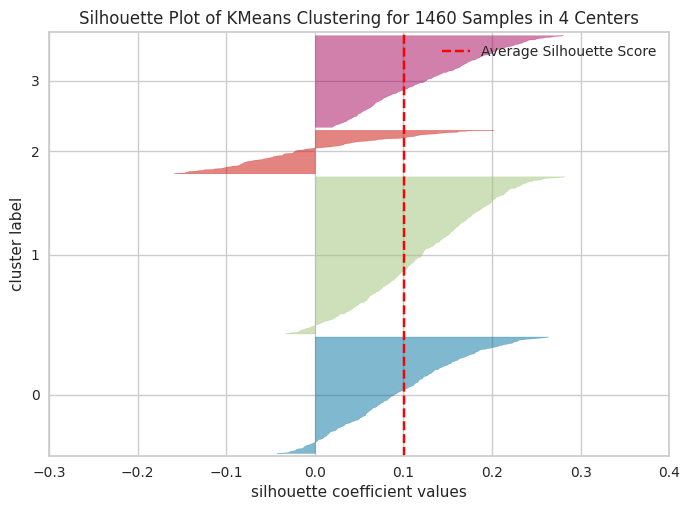



=== Silhouette plot for 5 Clusters ===


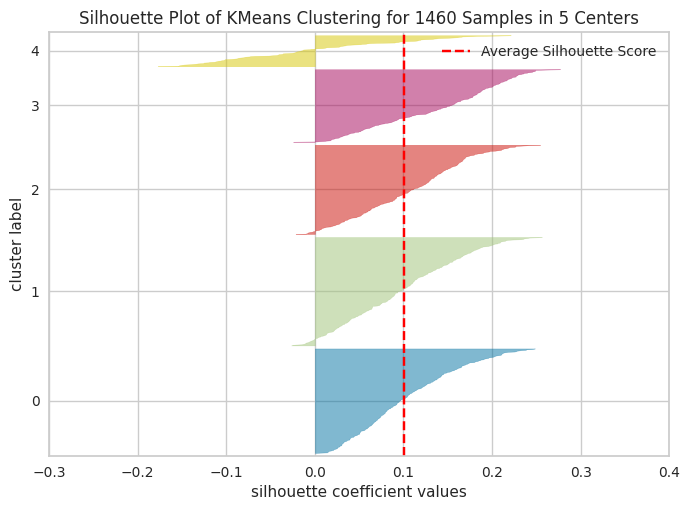



=== Silhouette plot for 6 Clusters ===


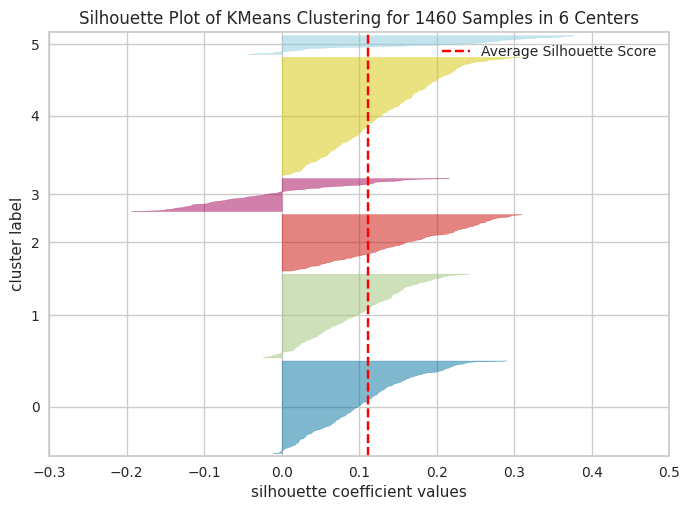



=== Silhouette plot for 7 Clusters ===


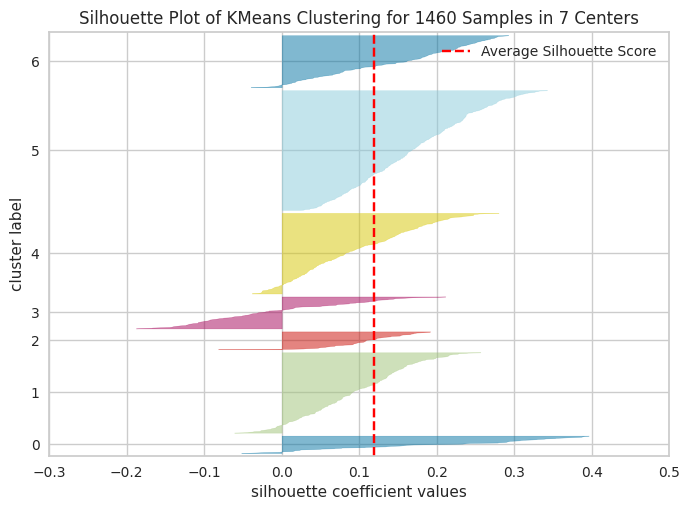

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 8

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

We will pick the most optimal cluster

In [13]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=14, random_state=0)),

        ("model", KMeans(n_clusters=4, random_state=0)),

    ])

    return pipeline_base

# Fit Cluster Pipeline

In [14]:
X = df.copy()
print(X.shape)
X.head(3)

(1460, 23)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotArea  \
0        150            0.0         548          RFn  ...     8450   
1        284            NaN         460          RFn  ...     9600   
2        434            0.0         608          RFn  ...    11250   

   LotFrontage MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  \
0         65.0      196.0           61            5            7          856   
1         80.0        0.0            0            8            6         1262   
2         68.0      162.0           42            5            7          920   

   WoodDeckSF  YearBuilt  YearRemodAdd  
0         0.0       2003          2003  
1         NaN       1976          1976  
2         NaN       2001          2002  

[3 rows x 23 columns]

In [15]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea', '2ndFlrSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variable...
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYr

# Add cluster predictions to dataset

We add a new column for clusters

In [16]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(1460, 24)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuilt  YearRemodAdd  Clusters  
0       2003          2003         0  
1       1976          1976         3  
2       2001          2002         0  

[3 rows x 24 columns]

* Clusters frequencies 
   Clusters
1      0.38
0      0.28
3      0.22
2      0.11 




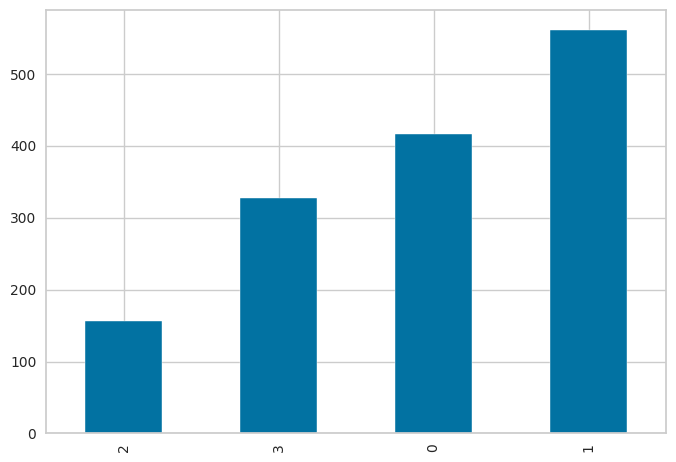

In [17]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

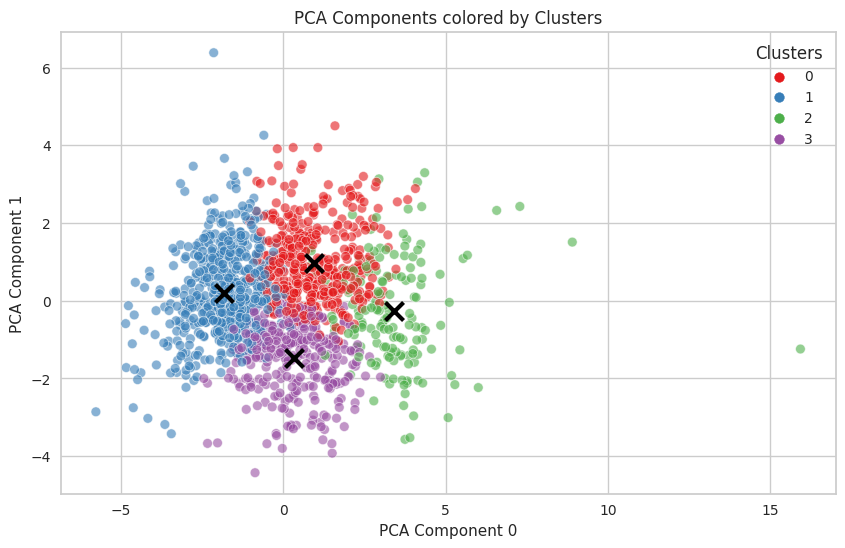

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

In [19]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       0
1       3
2       0
3       0
4       2
       ..
1455    0
1456    3
1457    0
1458    1
1459    1
Name: Clusters, Length: 1460, dtype: int32

# Fit a classifier, where the target is cluster predictions

In [20]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(1460, 24)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuilt  YearRemodAdd  Clusters  
0       2003          2003         0  
1       1976          1976         3  
2       2001          2002         0  

[3 rows x 24 columns]

Split Train and Test set

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.33,
    random_state=0
)

print(X_train.shape, X_test.shape)

(978, 23) (482, 23)


Now we fit a classifier to clustertarget variable pipeline

In [22]:
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingClassifier

def PipelineClf():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        ("model", GradientBoostingClassifier(random_state=0)),

    ])

    return pipeline_base

Fit train and test set

In [23]:
pipeline_clf_cluster = PipelineClf()
pipeline_clf_cluster.fit(X_train, y_train)

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea', '2ndFlrSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variable...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                      

# Evaluate classifier performance

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       275
           1       0.99      1.00      1.00       377
           2       1.00      0.96      0.98       113
           3       0.99      1.00      0.99       213

    accuracy                           0.99       978
   macro avg       0.99      0.99      0.99       978
weighted avg       0.99      0.99      0.99       978



In [25]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       141
           1       0.89      0.92      0.91       184
           2       0.78      0.84      0.81        43
           3       0.86      0.84      0.85       114

    accuracy                           0.86       482
   macro avg       0.85      0.85      0.85       482
weighted avg       0.86      0.86      0.86       482



# Assess the most important Features

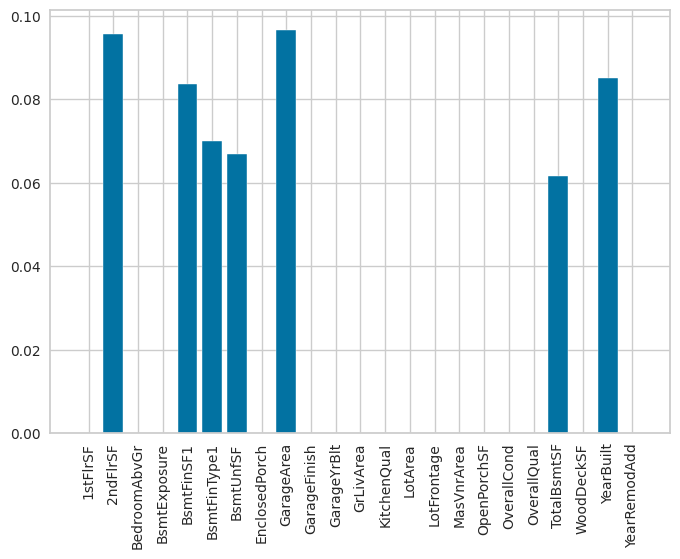

In [26]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    pipeline_clf_cluster, X_test, y_test, n_repeats=10, random_state=42
)

features = X_train.columns
best_features = feature_importances.importances_mean

plt.bar(features, best_features)
plt.xticks(rotation=90)
plt.show()


# Cluster Analysis

Using custom functions from CI to load tables and describe each variable

In [27]:
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters

def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)

    for col in EDA_Cluster.columns:

        try:

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription

In [28]:
import plotly.express as px

def cluster_distribution_per_variable(df, target):

    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show()

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show()

Save a copy of a cluster profile

In [29]:
df_cluster_profile = df_clf.copy()
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(1460, 24)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuilt  YearRemodAdd  Clusters  
0       2003          2003         0  
1       1976          1976         3  
2       2001          2002         0  

[3 rows x 24 columns]

Cluster profile based on the best features

In [30]:
df_sale = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv").filter(['SalePrice'])
df_sale['SalePrice'] = df_sale['SalePrice'].astype('object')
df_sale.head(3)

SalePrice
0    208500
1    181500
2    223500

In [31]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_sale], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_1292/3280396271.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_1292/3280396271.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_1292/3280396271.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_1292/3280396271.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


1stFlrSF      2ndFlrSF BedroomAbvGr  \
Cluster                                                
0         894.0 -- 1422.0  0.0 -- 918.0   3.0 -- 4.0   
1         816.0 -- 1112.0  0.0 -- 584.0   2.0 -- 3.0   
2        1515.0 -- 1968.0  0.0 -- 846.0   3.0 -- 3.0   
3         965.0 -- 1406.0    0.0 -- 0.0   2.0 -- 3.0   

                               BsmtExposure       BsmtFinSF1  \
Cluster                                                        
0         'No': 75% , 'Av': 13% , 'Mn': 7%      0.0 -- 430.0   
1        'No': 78% , 'Mn': 8% , 'None': 6%      0.0 -- 456.0   
2        'Gd': 33% , 'No': 31% , 'Av': 27%   699.0 -- 1322.0   
3        'No': 48% , 'Av': 29% , 'Gd': 16%    597.0 -- 992.0   

                                  BsmtFinType1        BsmtUnfSF EnclosedPorch  \
Cluster                                                                         
0         'Unf': 52% , 'GLQ': 27% , 'ALQ': 8%   410.0 -- 1222.0    0.0 -- 0.0   
1        'Unf': 35% , 'BLQ': 19% , 'Rec': 18%    229.0 -- 728.0   0.0 -- 48.0   
2         'GLQ': 71% , 'Unf': 12% , 'ALQ': 9%    312.0 -- 878.0    0.0 -- 0.0   
3         'GLQ': 58% , 'ALQ': 33% , 'BLQ': 5%    100.0 -- 426.0    0.0 -- 0.0   

             GarageArea                           GarageFinish  ...  \
Cluster                                                         ...   
0        454.0 -- 642.0  'RFn': 49% , 'Fin': 31% , 'Unf': 21%   ...   
1        240.0 -- 440.0  'Unf': 70% , 'None': 14% , 'RFn': 9%   ...   
2        588.0 -- 841.0   'Fin': 61% , 'RFn': 30% , 'Unf': 9%   ...   
3        432.0 -- 576.0  'Unf': 36% , 'RFn': 35% , 'Fin': 28%   ...   

           LotFrontage      MasVnrArea    OpenPorchSF OverallCond OverallQual  \
Cluster                                                                         
0         65.0 -- 86.0    0.0 -- 224.0  30.0 -- 108.0  5.0 -- 5.0  6.0 -- 7.0   
1         52.0 -- 72.0      0.0 -- 0.0    0.0 -- 20.0  5.0 -- 7.0  5.0 -- 6.0   
2        77.0 -- 100.0  168.0 -- 480.0  44.0 -- 122.0  5.0 -- 5.0  7.0 -- 9.0   
3         48.0 -- 78.0    0.0 -- 145.0    0.0 -- 51.0  5.0 -- 6.0  5.0 -- 7.0   

              TotalBsmtSF      WoodDeckSF         YearBuilt      YearRemodAdd  \
Cluster                                                                         
0         818.0 -- 1338.0    0.0 -- 144.0  1976.0 -- 2004.0  1991.0 -- 2005.0   
1         672.0 -- 1001.0    0.0 -- 141.0  1925.0 -- 1962.0  1950.0 -- 1994.0   
2        1479.0 -- 1930.0  144.0 -- 208.0  1994.0 -- 2007.0  1996.0 -- 2007.0   
3         902.0 -- 1346.0    0.0 -- 180.0  1970.0 -- 2000.0  1976.0 -- 2004.0   

                                           SalePrice  
Cluster                                               
0        '200000': 2% , '174000': 2% , '190000': 2%   
1        '135000': 2% , '115000': 2% , '140000': 2%   
2        '315000': 2% , '320000': 2% , '280000': 2%   
3        '145000': 2% , '175000': 2% , '180000': 2%   

[4 rows x 24 columns]

In [32]:
df_cluster=  df_sale.copy()
df_cluster['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster, target='SalePrice')

Clusters distribution across SalePrice levels


Relative Percentage (%) of SalePrice in each cluster


In [52]:
df_reduced = df.filter(['2ndFlrSF','BsmtFinType1','BsmtFinSF1','BsmtUnfSF','GarageArea','TotalBsmtSF','YearBuilt'])
df_reduced.head(5)

2ndFlrSF BsmtFinType1  BsmtFinSF1  BsmtUnfSF  GarageArea  TotalBsmtSF  \
0     854.0          GLQ         706        150         548          856   
1       0.0          ALQ         978        284         460         1262   
2     866.0          GLQ         486        434         608          920   
3       NaN          ALQ         216        540         642          756   
4       NaN          GLQ         655        490         836         1145   

   YearBuilt  
0       2003  
1       1976  
2       2001  
3       1915  
4       2000

# Rewrite Cluster Pipeline with the most relevant variables

In [63]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtFinType1'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),

        ("scaler", StandardScaler()),

        ("model", KMeans(n_clusters=4, random_state=0)),

    ])

    return pipeline_base

PipelineCluster()

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtFinType1'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=4, random_state=0))])

In [64]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

(1460, 7) 
 <class 'numpy.ndarray'>


## Apply Elbow Method and Silhouette analysis

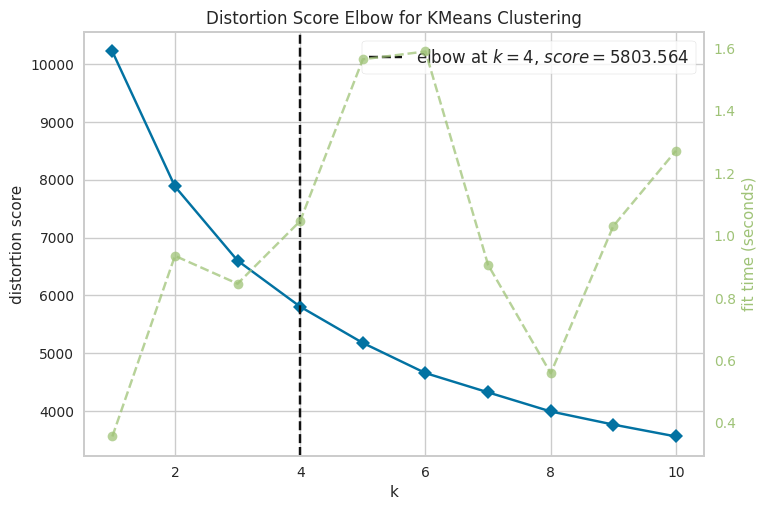

In [65]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


/home/codeany/.local/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/home/codeany/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



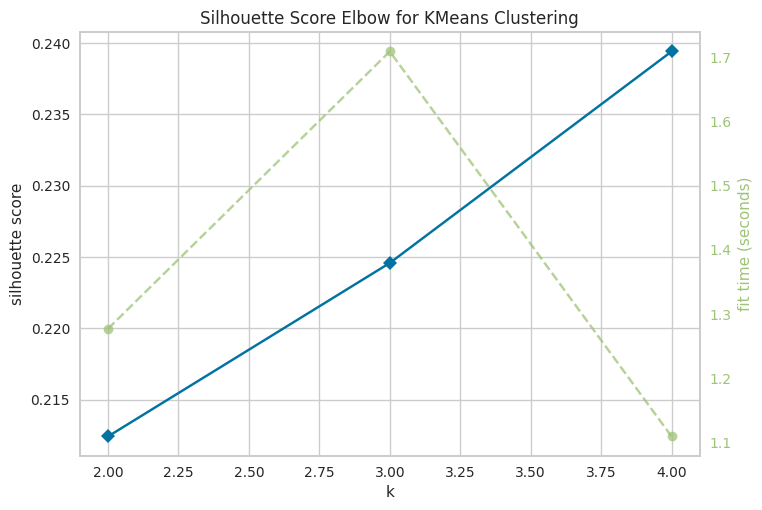



=== Silhouette plot for 2 Clusters ===


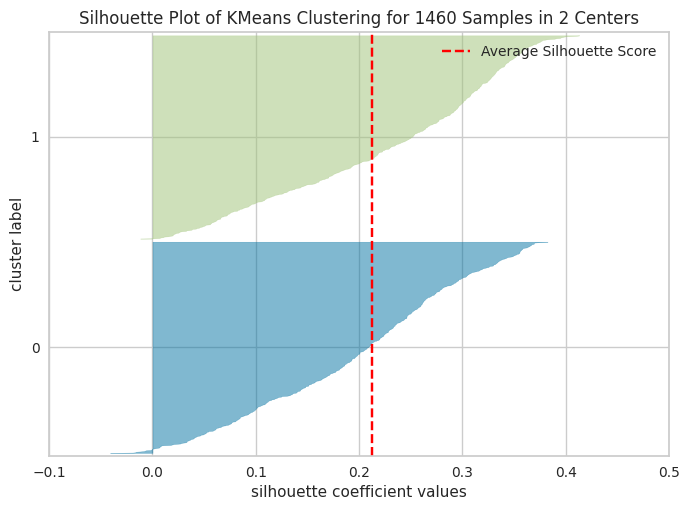



=== Silhouette plot for 3 Clusters ===


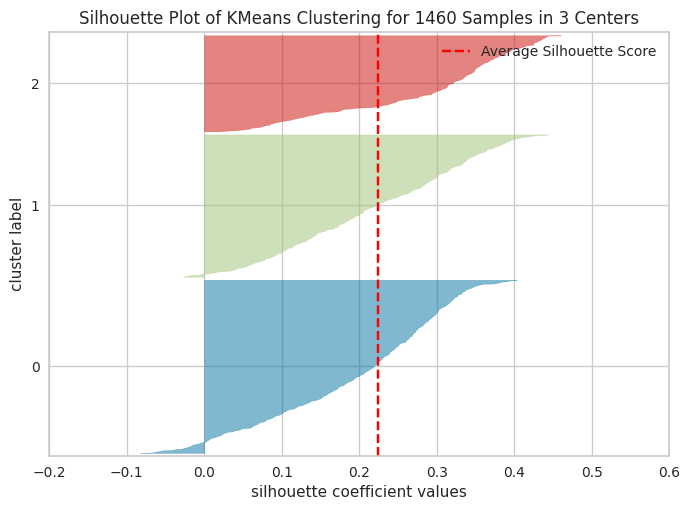



=== Silhouette plot for 4 Clusters ===


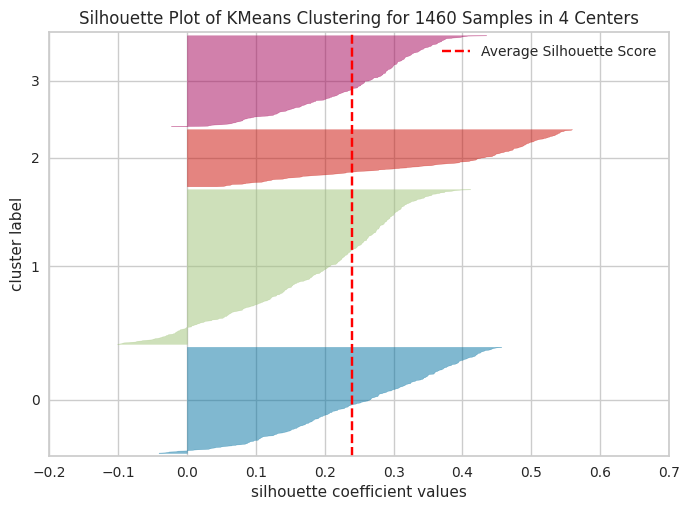

In [66]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 5

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

In [67]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

(1460, 7)


2ndFlrSF BsmtFinType1  BsmtFinSF1  BsmtUnfSF  GarageArea  TotalBsmtSF  \
0     854.0          GLQ         706        150         548          856   
1       0.0          ALQ         978        284         460         1262   
2     866.0          GLQ         486        434         608          920   

   YearBuilt  
0       2003  
1       1976  
2       2001

In [68]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtFinType1'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=4, random_state=0))])

In [69]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(1460, 8)


2ndFlrSF BsmtFinType1  BsmtFinSF1  BsmtUnfSF  GarageArea  TotalBsmtSF  \
0     854.0          GLQ         706        150         548          856   
1       0.0          ALQ         978        284         460         1262   
2     866.0          GLQ         486        434         608          920   

   YearBuilt  Clusters  
0       2003         3  
1       1976         0  
2       2001         3

* Clusters frequencies 
   Clusters
1      0.38
0      0.26
3      0.22
2      0.14 




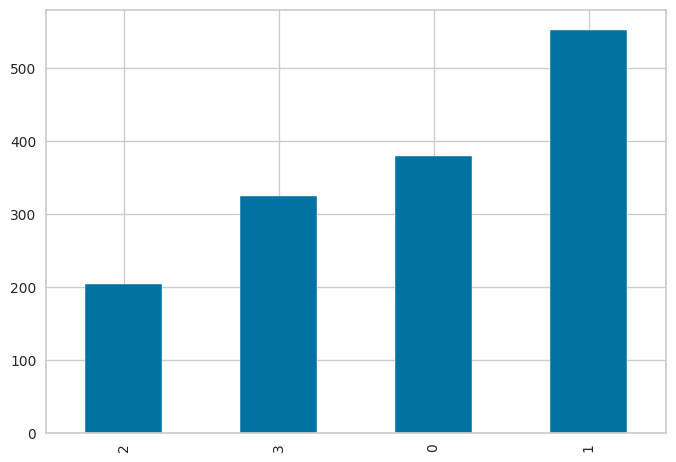

In [70]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

In [71]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

0       3
1       0
2       3
3       1
4       0
       ..
1455    3
1456    0
1457    3
1458    1
1459    1
Name: Clusters, Length: 1460, dtype: int32

In [77]:
from sklearn.metrics import confusion_matrix

confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features)

array([[  8,  31, 130, 247],
       [ 15, 506,  21,  19],
       [ 91,   2,  30,  33],
       [265,  13,  23,  26]])